In [ ]:
# # Parameters
# h5ad_subset = "/data/work/test1/test2/cotton_K2.hr.rds.rh.h5ad"
# cluster_key = "RNA_snn_res.0.5"
# h5ad_all = "/data/users/yangdong/yangdong_faff775391984da0a355d4bd70217714/online/cotton/output/dataget/K2/cotton_K2.h5ad"
# cluster_key_all = "leiden_res_0.50"
# n_pc = 1
# root_cluster = 0
# use_argmin = "yes"


# Diffusion pseudotime
[Reference](https://github.com/theislab/cellrank2_reproducibility/tree/main/notebooks/cytotrace_kernel/embryoid_bodyhttps://github.com/theislab/cellrank2_reproducibility/tree/main/notebooks/cytotrace_kernel/embryoid_body)

**Log:** 250826

## Library imports

In [2]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv

# sys.path.extend(["../../../", "."])
# from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

## General settings

In [3]:
sc.settings.verbosity = 2
scv.settings.verbosity = 3

scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

SAVE_FIGURES = False
FIG_DIR = 'dpt'

from pathlib import Path

FIG_DIR = Path(FIG_DIR)     # 把原来的字符串改成 Path

if SAVE_FIGURES:
    (FIG_DIR).mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "pdf"

## Data loading

In [4]:
adata = sc.read_h5ad(h5ad_subset)
prefix = os.path.splitext(os.path.basename(h5ad_subset))[0]
adata

AnnData object with n_obs × n_vars = 537 × 27363
    obs: 'nCount_RNA', 'nFeature_RNA', 'new_index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'doublet_score', 'leiden', 'leiden_res_0.20', 'leiden_res_0.80', 'leiden_res_1.00', 'leiden_res_1.30', 'leiden_res_1.60', 'leiden_res_2.00', 'RNA_snn_res.0.5', 'seurat_clusters', 'sample'
    var: 'new_index', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_xpca_', 'X_xumap_'
    layers: 'counts'
 

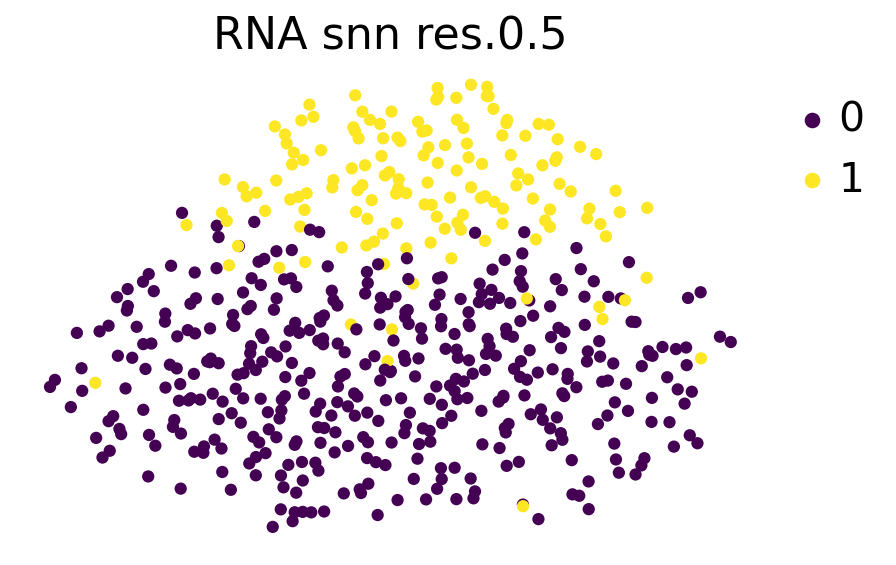

In [5]:
scv.pl.scatter(adata, basis="umap", c=cluster_key, palette="viridis")

## Pseudotime construction

In [6]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)


computing transitions


    finished (0:00:00)


    eigenvalues of transition matrix
    [ 1.          0.8386006   0.699858    0.6950569   0.6818139   0.66979146
      0.65154713  0.64066553  0.63798606  0.6302836   0.62466943  0.6221715
      0.6198808   0.6139602  -0.6109614 ]


    finished (0:00:00)


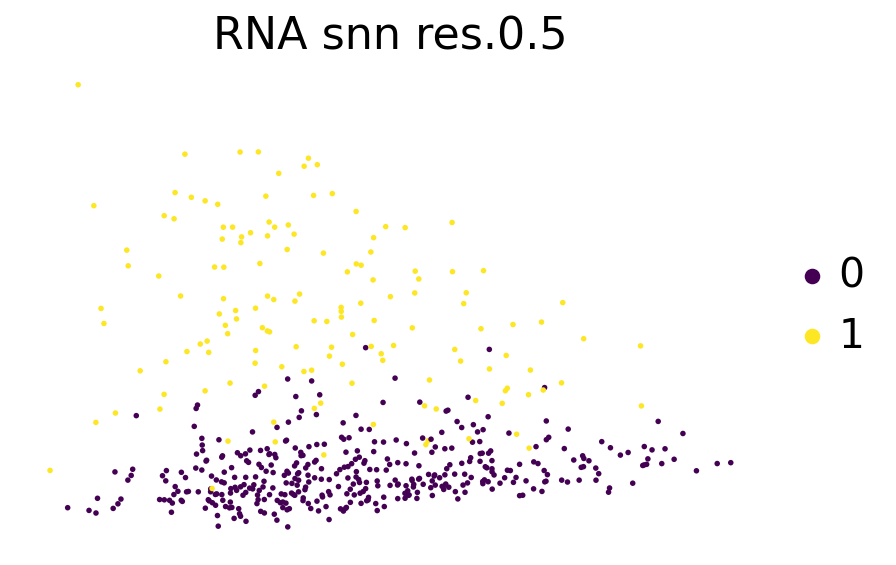

In [7]:
scv.pl.scatter(adata, basis="diffmap", color=[cluster_key], legend_loc="right", components="0, 1", size=25)

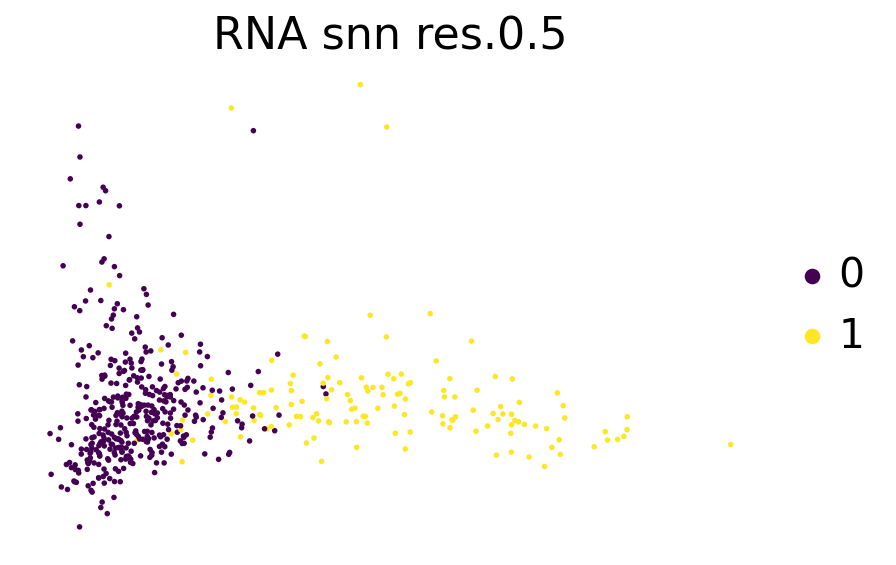

In [8]:
scv.pl.scatter(adata, basis="diffmap", color=[cluster_key], legend_loc="right", components="1, 2", size=25)

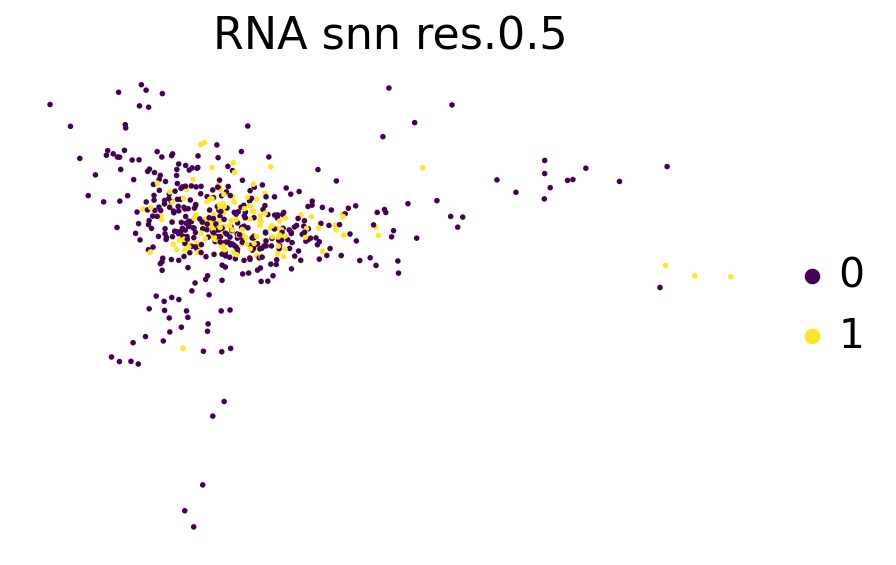

In [9]:
scv.pl.scatter(adata, basis="diffmap", color=[cluster_key], legend_loc="right", components="2, 3", size=25)

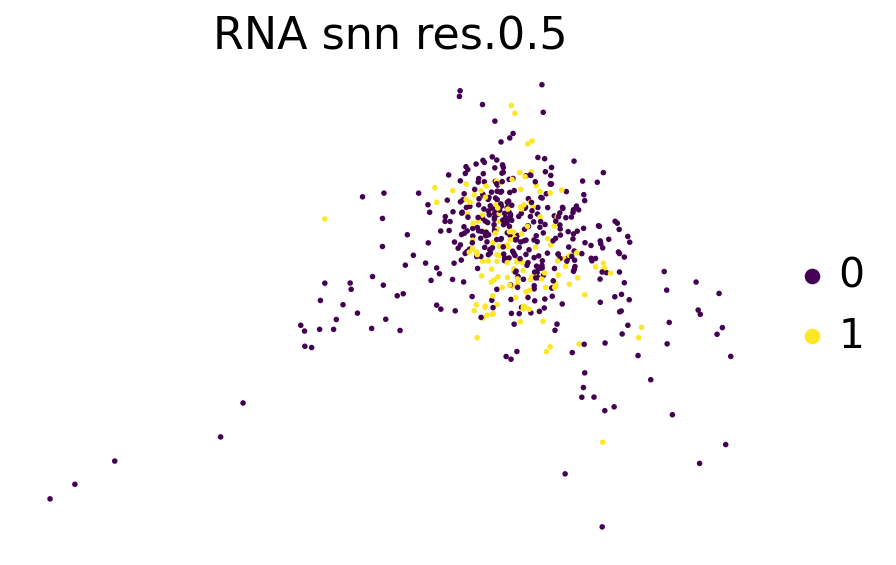

In [10]:
scv.pl.scatter(adata, basis="diffmap", color=[cluster_key], legend_loc="right", components="3, 4", size=25)

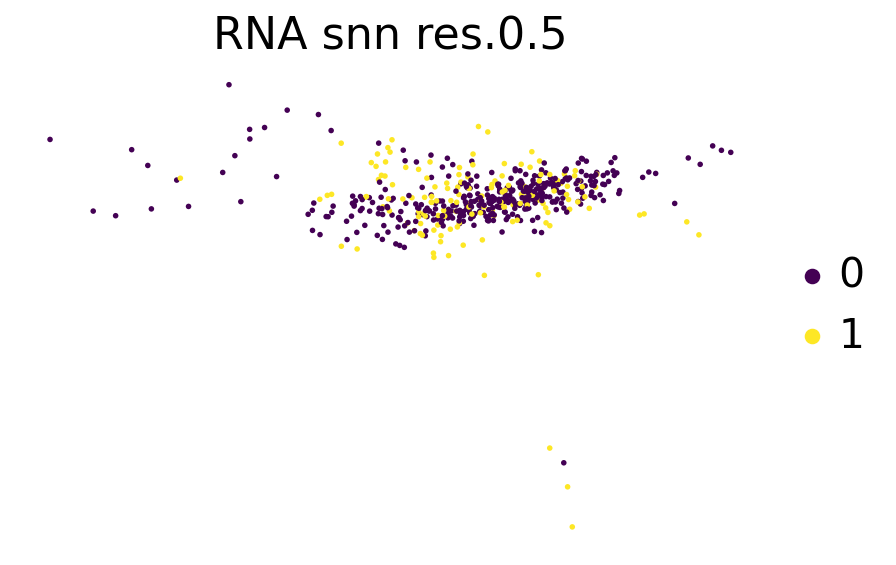

In [11]:
scv.pl.scatter(adata, basis="diffmap", color=[cluster_key], legend_loc="right", components="4, 5", size=25)

root_idx: 384


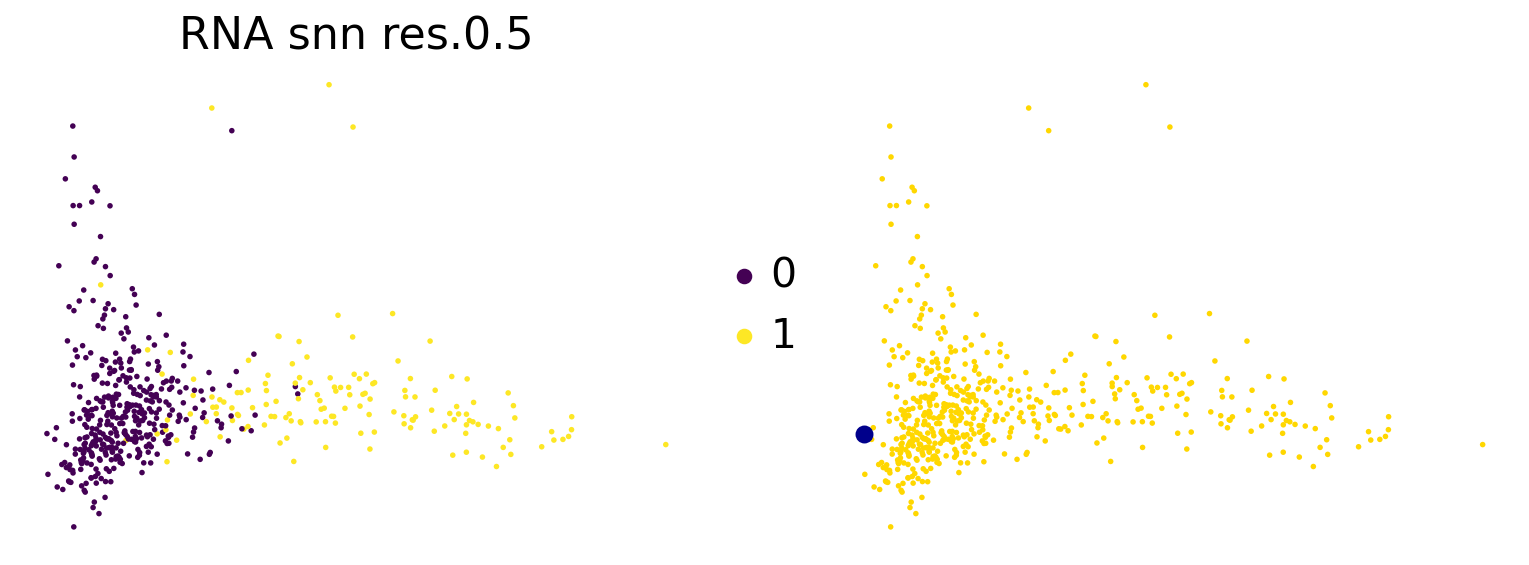

In [12]:
import pandas as pd
df = (
    pd.DataFrame(
        {
            "diff_comp": adata.obsm["X_diffmap"][:, n_pc],
            "cell_type": adata.obs[cluster_key].values,
        }
    )
    .reset_index()
    .rename({"index": "obs_id"}, axis=1)
)
df.head()
df = df.loc[df["cell_type"] == str(root_cluster), "diff_comp"]
if use_argmin == 'yes':
    root_idx = df.index[df.argmin()]
else: 
    root_idx = df.index[df.argmax()]
print(f'root_idx: {root_idx}')
scv.pl.scatter(adata, basis="diffmap", color=[cluster_key, root_idx], legend_loc="right", components="1, 2", size=25)

In [13]:
# root_idx = 1458  # adata.obsm['X_diffmap'][:, 1].argmin()
# scv.pl.scatter(adata, basis="diffmap", color=["cell_type", root_idx], legend_loc="right", components="1, 2", size=25)

In [14]:
adata.uns["iroot"] = root_idx

In [15]:
dpt_pseudotime = sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10


    finished (0:00:00)


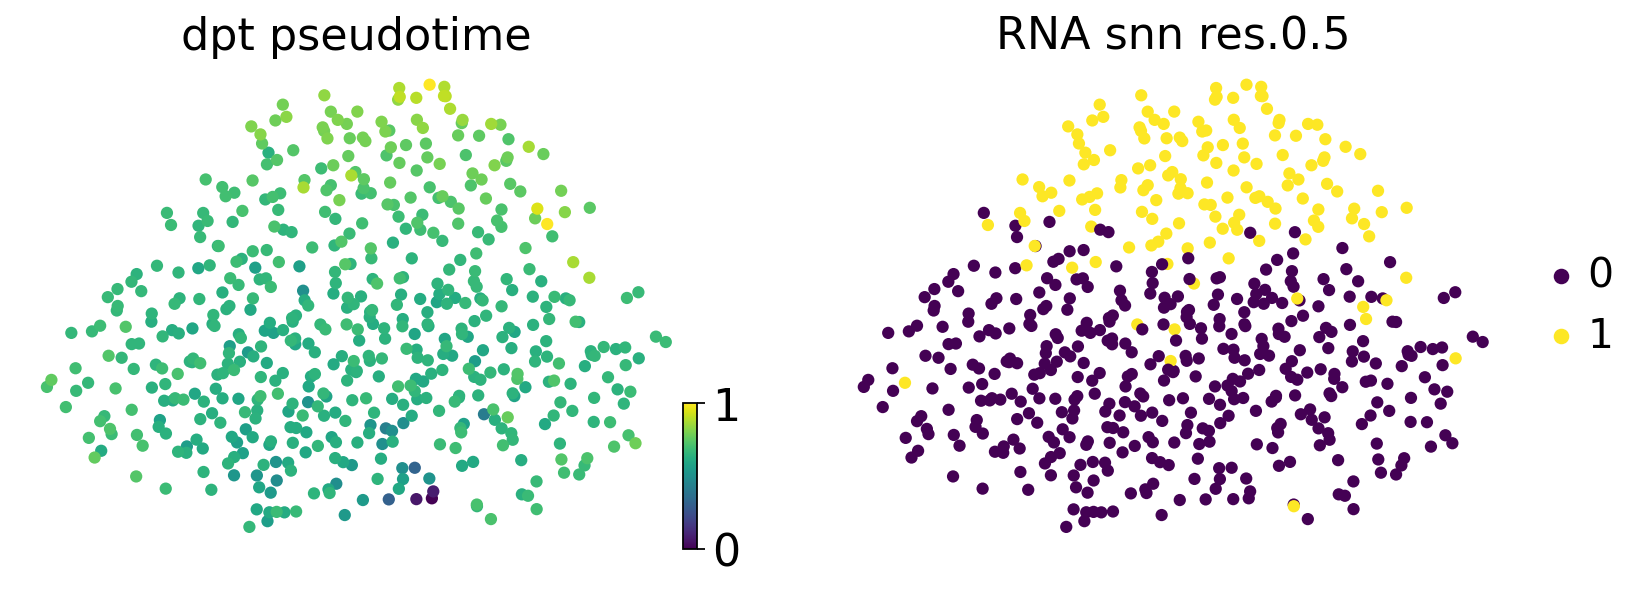

In [16]:
scv.pl.scatter(
    adata,
    c=["dpt_pseudotime", cluster_key],
    basis="umap",
    legend_loc="right",
    color_map="viridis",
)

if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata, basis="umap", c="dpt_pseudotime", title="", legend_loc=False, colorbar=False, cmap="gnuplot2", ax=ax
    )

    fig.savefig(
        FIG_DIR / f"umap_colored_by_dpt_pseudotime.{FIGURE_FORMAT}",
        format=FIGURE_FORMAT,
        transparent=True,
        bbox_inches="tight",
    )

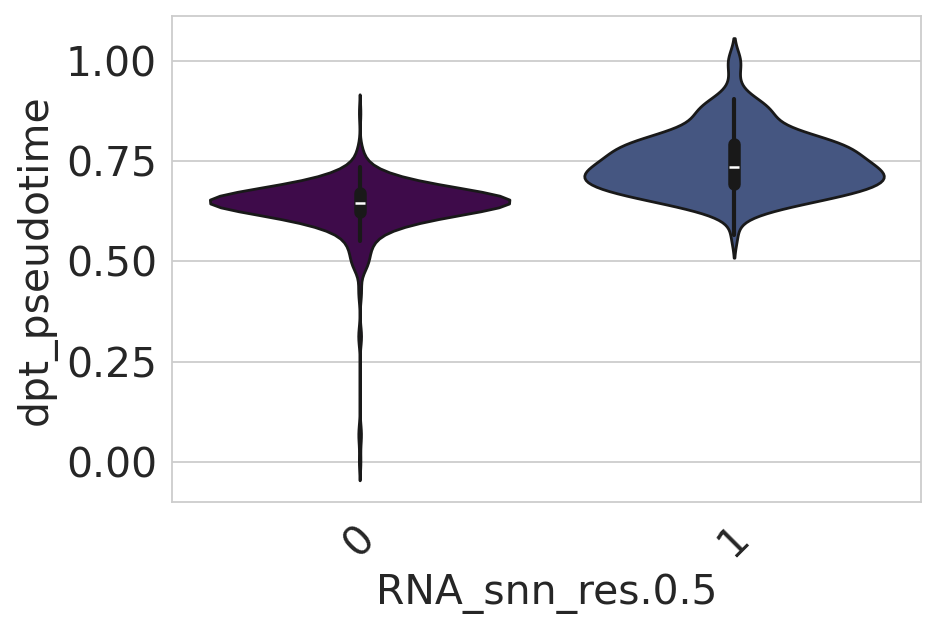

In [17]:
df = adata.obs[["dpt_pseudotime", cluster_key]].copy()

sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(
    data=df,
    x=cluster_key,
    y="dpt_pseudotime",
    scale="width",
    palette=["#440154", "#3b528b", "#21918c", "#5ec962", "#fde725"],
    ax=ax,
)

ax.tick_params(axis="x", rotation=45)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.show()

if SAVE_FIGURES:
    ax.set(xlabel=None, xticklabels=[], ylabel=None, yticklabels=[])

    fig.savefig(
        FIG_DIR / f"dpt_vs_stage.{FIGURE_FORMAT}",
        format=FIGURE_FORMAT,
        transparent=True,
        bbox_inches="tight",
    )
sns.reset_orig()

In [18]:
adata.write_h5ad(f"{prefix}_dpt.h5ad",compression='gzip')

# See in whole umap
**Why:** 取子集之前的umap可以展示亚群的位置，且早期细胞相比晚期细胞越靠内

In [19]:
adata2 = sc.read_h5ad(h5ad_all)
adata2

AnnData object with n_obs × n_vars = 11021 × 27363
    obs: 'sample', 'biosample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_res_0.02', 'leiden_res_0.20', 'leiden_res_0.50', 'leiden_res_0.80', 'leiden_res_1.00', 'leiden_res_1.30', 'leiden_res_1.60', 'leiden_res_2.00'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dendrogram_leiden_res_0.20', 'dendrogram_leiden_res_0.50', 'dendrogram_leiden_res_0.80', 'dendrogram_leiden_res_1.00', 'dendrogram_leiden_res_1.30', 'dendrogram_leiden_res_1.60', 'dendrogram_leiden_res_2.00', 'hvg', 'leiden', 

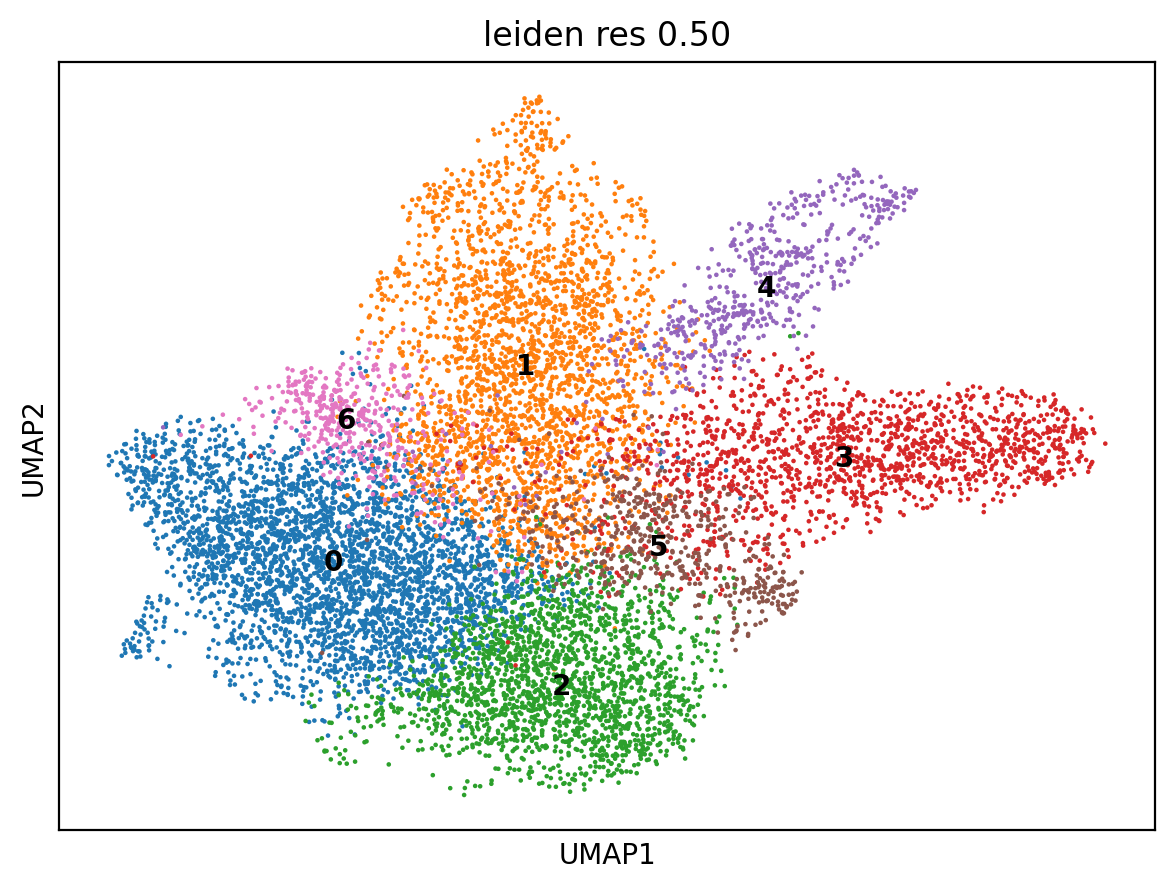

In [20]:
sc.pl.scatter(adata2, basis='umap', color=cluster_key_all, legend_loc='on data')

            sample  biosample  n_genes_by_counts  log1p_n_genes_by_counts  \
CELL2_N3_K2     K2  cotton_K2               2655                 7.884577   
CELL3_N2_K2     K2  cotton_K2               1644                 7.405496   
CELL5_N4_K2     K2  cotton_K2               1313                 7.180831   
CELL8_N2_K2     K2  cotton_K2               1008                 6.916715   
CELL9_N3_K2     K2  cotton_K2               2461                 7.808729   

             total_counts  log1p_total_counts  pct_counts_in_top_50_genes  \
CELL2_N3_K2        3891.0            8.266679                   14.006682   
CELL3_N2_K2        2169.0            7.682482                   13.047487   
CELL5_N4_K2        1635.0            7.400010                   12.660550   
CELL8_N2_K2        1284.0            7.158514                   14.641745   
CELL9_N3_K2        3634.0            8.198364                   14.914695   

             pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
C

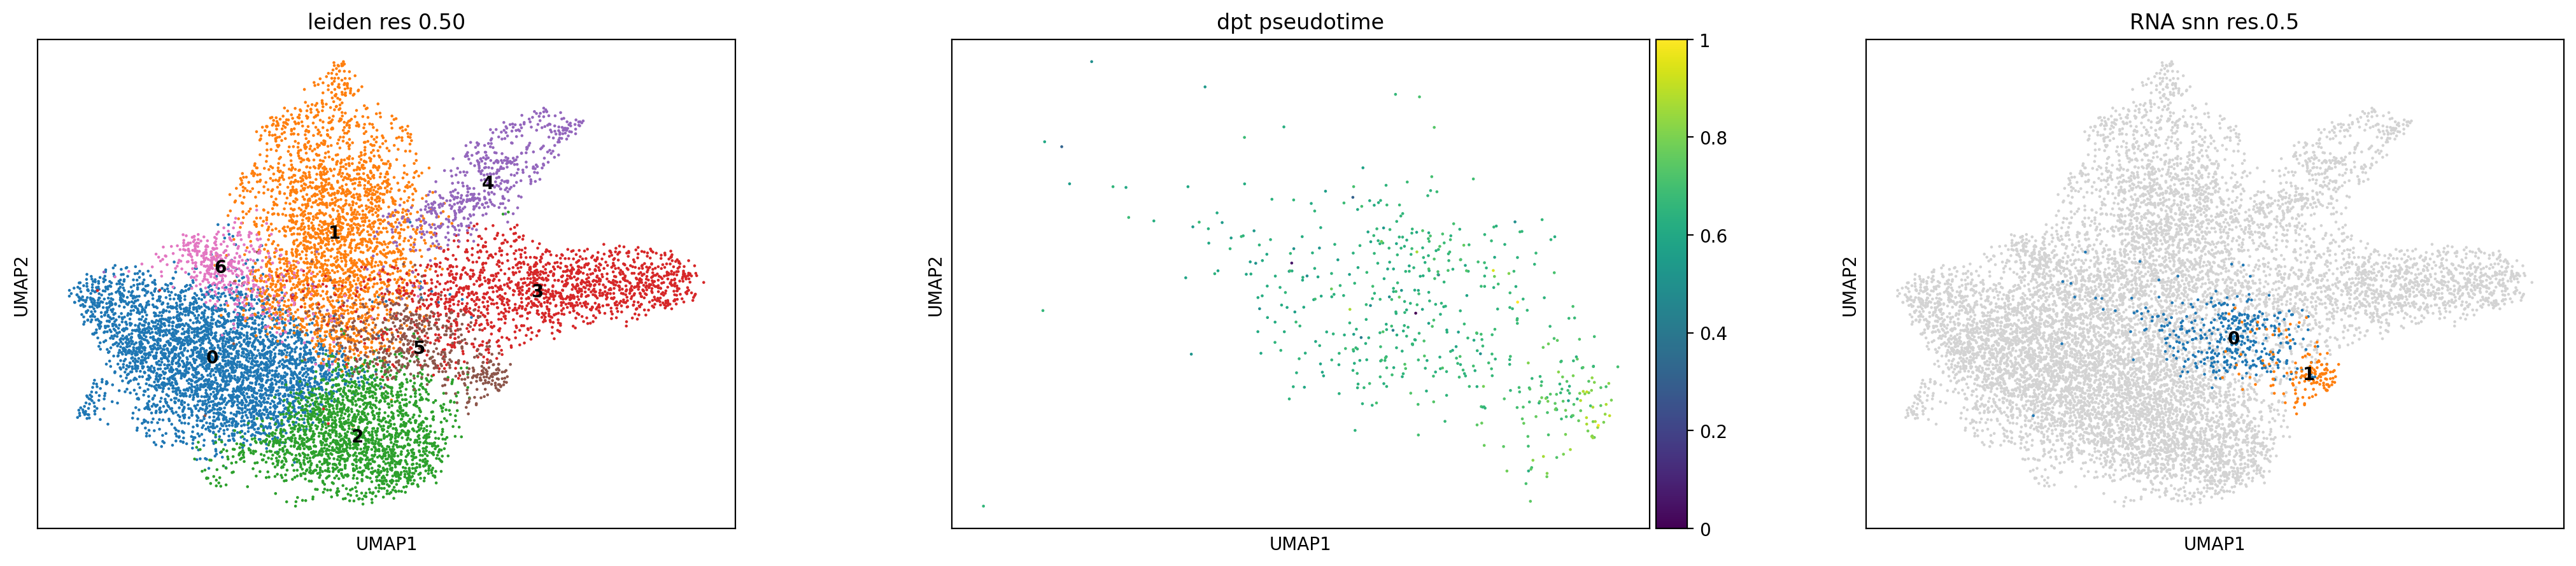

In [21]:
data = adata.obs
data = data[['dpt_pseudotime', cluster_key]]

data.index = data.index.astype(str)
# 1) 建立全量 DataFrame，缺失填 NaN
full_df = data.reindex(adata2.obs.index)
# 2) 把列写回 adata2.obs
for col in full_df.columns:
    adata2.obs[col] = full_df[col]
# 3) （可选）确认
print(adata2.obs.head())
#sc.pl.scatter(adata2, basis="umap", color=["Ga12g00054", "Ga14g00277"], legend_loc='on data')
sc.pl.scatter(adata2, basis="umap", color=[cluster_key_all, "dpt_pseudotime", cluster_key], legend_loc='on data')

# # 1. 新建一列，只把目标细胞设为 True
# cell_barcode = "CELL47239_N1_1"
# adata2.obs["highlight"] = adata2.obs_names == cell_barcode

# # 2. 画图
# sc.pl.scatter(
#     adata2,
#     basis="umap",
#     color="highlight",
#     legend_loc="on data",
#     save=f"_{prefix}_root_dpt_pseudotime.pdf"
# )